# Fingerprint distances between structures for the same kinase

In this notebook, we investigate the ranges of fingerprint distances for each kinase pair.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_local

from kissim.comparison import FingerprintDistanceGenerator
from kissim.encoding import FingerprintGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/20210324/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_local(HERE / "../../data/external/20210114_KLIFS_HUMAN/")
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = DATA / "fingerprint_distances_41-41-41-41-41-41-41-41-83-83-83-83-111-111-111.json"

In [9]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_json(fingerprint_distance_file)

In [10]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 293
Number of structures: 4918


In [11]:
structure_distances = fingerprint_distance_generator.data

### Remove unwanted structures

In [12]:
# Remove code after when using latest data
structure_distances = structure_distances[
        ~structure_distances.apply(
        lambda x: (x["structure1"] in [59, 7083]) or (x["structure2"] in [59, 7083]), 
        axis=1
    )
]

### Sort fingerprint/kinase pairs (alphabetically)

In [13]:
# Takes 2 minutes
%time structure_distances["structure_pair"] = structure_distances[["structure1", "structure2"]].apply(list, axis=1).apply(sorted)
%time structure_distances["kinase_pair"] = structure_distances[["kinase1", "kinase2"]].apply(list, axis=1).apply(sorted)

structure_distances["structure1"] = [i[0] for i in structure_distances["structure_pair"]]
structure_distances["structure2"] = [i[1] for i in structure_distances["structure_pair"]]
structure_distances["kinase1"] = [i[0] for i in structure_distances["kinase_pair"]]
structure_distances["kinase2"] = [i[1] for i in structure_distances["kinase_pair"]]
structure_distances = structure_distances.drop(["structure_pair", "kinase_pair"], axis=1)
structure_distances.head()

CPU times: user 1min 11s, sys: 1.24 s, total: 1min 13s
Wall time: 1min 13s
CPU times: user 1min 8s, sys: 976 ms, total: 1min 9s
Wall time: 1min 9s


,structure1,structure2,kinase1,kinase2,distance,coverage
0,3835,6679,AAK1,AAK1,0.053726,0.995417
1,3835,7156,AAK1,AAK1,0.066557,0.994583
2,1104,3835,AAK1,ABL1,0.251198,0.994167
3,1065,3835,AAK1,ABL1,0.264613,0.994167
4,1090,3835,AAK1,ABL1,0.233935,0.994167


### Add DFG conformation

In [14]:
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
%time structure_distances["dfg1"] = structure_distances["structure1"].apply(lambda x: dfg[x])
%time structure_distances["dfg2"] = structure_distances["structure2"].apply(lambda x: dfg[x])

CPU times: user 29.7 s, sys: 168 ms, total: 29.9 s
Wall time: 29.9 s
CPU times: user 31 s, sys: 196 ms, total: 31.2 s
Wall time: 31.2 s


### Filter distances by coverage cutoff

In [15]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["coverage"].values < COVERAGE_CUTOFF, np.nan, structure_distances["distance"].values
)
structure_distances.head()

,structure1,structure2,kinase1,kinase2,distance,coverage,dfg1,dfg2,distance_filtered
0,3835,6679,AAK1,AAK1,0.053726,0.995417,in,in,0.053726
1,3835,7156,AAK1,AAK1,0.066557,0.994583,in,in,0.066557
2,1104,3835,AAK1,ABL1,0.251198,0.994167,out-like,in,0.251198
3,1065,3835,AAK1,ABL1,0.264613,0.994167,out,in,0.264613
4,1090,3835,AAK1,ABL1,0.233935,0.994167,in,in,0.233935


In [16]:
structure_distances_filtered = structure_distances[structure_distances["distance_filtered"].notna()]

In [17]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 12081070
Structure pairs not-NaN: 11851916


## Structure distances

### Structure distance distributions for different subsets

- All structure distances
- Structure distances between the same kinases
- Structure distances between different kinases

#### Without coverage cutoff

In [18]:
structure_distances_df = pd.DataFrame(
    {
        "all": structure_distances["distance"],
        "intra-kinase": structure_distances[
            structure_distances["kinase1"] == structure_distances["kinase2"]
        ]["distance"],
        "inter-kinase": structure_distances[
            ~(structure_distances["kinase1"] == structure_distances["kinase2"])
        ]["distance"]
    }
)

In [19]:
structure_distances_df.notna().sum()

all             12081070
intra-kinase      246276
inter-kinase    11834794
dtype: int64

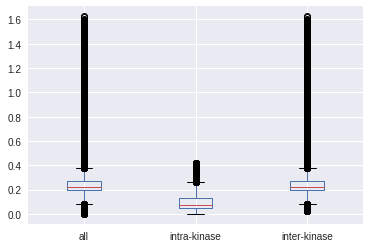

In [20]:
structure_distances_df.plot(kind="box");

In [21]:
structure_distances_df.describe()

,all,intra-kinase,inter-kinase
count,1.208107e+07,246276.000000,1.183479e+07
mean,2.388859e-01,0.089753,2.419893e-01
std,7.692140e-02,0.056100,7.417608e-02
min,0.000000e+00,0.000000,2.624518e-02
25%,1.931432e-01,0.046435,1.951009e-01
50%,2.235989e-01,0.069840,2.248342e-01
75%,2.671089e-01,0.132246,2.685162e-01
max,1.626587e+00,0.419469,1.626587e+00


#### With coverage cutoff

In [22]:
structure_distances_filtered_df = pd.DataFrame(
    {
        "all": structure_distances_filtered["distance"],
        "intra-kinase": structure_distances_filtered[
            structure_distances_filtered["kinase1"] == structure_distances_filtered["kinase2"]
        ]["distance"],
        "inter-kinase": structure_distances_filtered[
            ~(structure_distances_filtered["kinase1"] == structure_distances_filtered["kinase2"])
        ]["distance"]
    }
)

In [23]:
structure_distances_filtered_df.notna().sum()

all             11851916
intra-kinase      244509
inter-kinase    11607407
dtype: int64

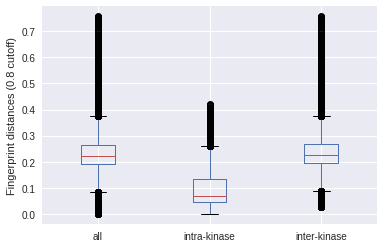

In [24]:
fig, axes = plt.subplots(1, 1)
structure_distances_filtered_df.plot(kind="box", ax=axes);
axes.set_ylabel(f"Fingerprint distances ({COVERAGE_CUTOFF} cutoff)");

In [25]:
structure_distances_filtered_df.describe()

,all,intra-kinase,inter-kinase
count,1.185192e+07,244509.000000,1.160741e+07
mean,2.370296e-01,0.089543,2.401364e-01
std,7.170763e-02,0.055991,6.867605e-02
min,0.000000e+00,0.000000,2.624518e-02
25%,1.927443e-01,0.046332,1.947127e-01
50%,2.229435e-01,0.069633,2.241750e-01
75%,2.654165e-01,0.131997,2.667881e-01
max,7.574618e-01,0.419469,7.574618e-01


### Per kinase distributions

How robust are structure distances within kinase pairs?

#### All kinase pairs

In [26]:
data = structure_distances_filtered[["kinase1", "kinase2", "distance"]].groupby(["kinase1", "kinase2"])

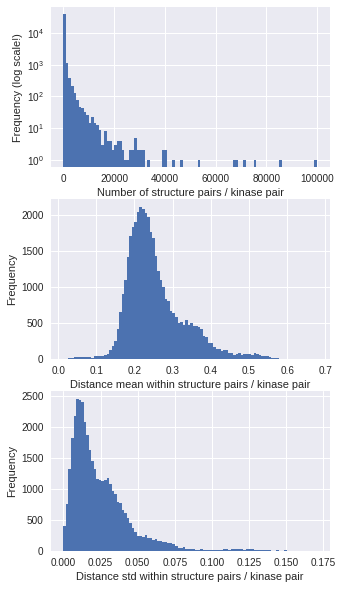

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
# Size
data.size().plot(ax=axes[0], kind="hist", logy=True, style=".", bins=100)
axes[0].set_xlabel("Number of structure pairs / kinase pair")
axes[0].set_ylabel("Frequency (log scale!)")
# Mean
data.mean().squeeze().plot(ax=axes[1], kind="hist", style=".", bins=100)
axes[1].set_xlabel("Distance mean within structure pairs / kinase pair")
# Std
data.std().squeeze().plot(ax=axes[2], kind="hist", logy=False, style=".", bins=100)
axes[2].set_xlabel("Distance std within structure pairs / kinase pair");

In [28]:
print("size == 1: ", data.size()[data.size() == 1].shape[0])
print("size < 5: ", data.size()[data.size() < 5].shape[0])
print("size < 10: ", data.size()[data.size() < 10].shape[0])
print("size < 100: ", data.size()[data.size() < 100].shape[0])
print("size < 1000: ", data.size()[data.size() < 1000].shape[0])
print("size < 10000: ", data.size()[data.size() < 10000].shape[0])
print("size: ", data.size().shape[0])

size == 1:  1809
size < 5:  7312
size < 10:  12061
size < 100:  29137
size < 1000:  38505
size < 10000:  40556
size:  40695


In [29]:
data.mean().describe()

,distance
count,40695.000000
mean,0.254595
std,0.076776
min,0.013667
25%,0.203749
50%,0.236724
75%,0.288148
max,0.678254


In [30]:
data.std().describe()

,distance
count,38886.000000
mean,0.024682
std,0.020206
min,0.000004
25%,0.010802
50%,0.018944
75%,0.032899
max,0.170672


#### Most frequent kinase pairs (all conformations)

In [31]:
data = structure_distances_filtered.groupby(["kinase1", "kinase2"])

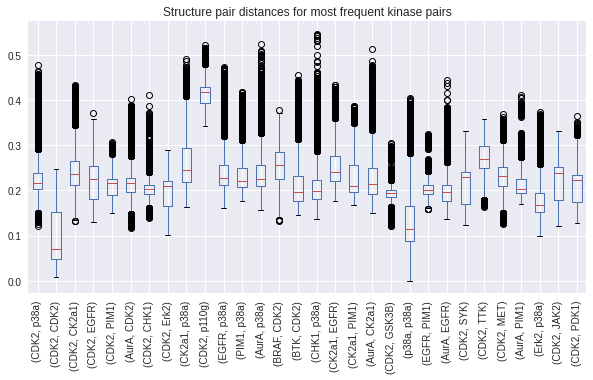

In [32]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10,5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

In [33]:
data_min = data.min()

In [34]:
print("Minimum pair has same conformations")
print(data_min[data_min["dfg1"] == data_min["dfg2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has same conformations
91.3724044722939


In [35]:
print("Minimum pair has different conformations")
print(data_min[data_min["dfg1"] != data_min["dfg2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has different conformations
8.627595527706108


#### Most frequent kinase pairs (DFG-in conformations only)

In [36]:
structure_distances_filtered_dfgin = structure_distances_filtered[
    (structure_distances_filtered["dfg1"] == "in") & (structure_distances_filtered["dfg2"] == "in")
]
structure_distances_filtered.shape, structure_distances_filtered_dfgin.shape

((11851916, 9), (8904825, 9))

In [37]:
data = structure_distances_filtered_dfgin.groupby(["kinase1", "kinase2"])

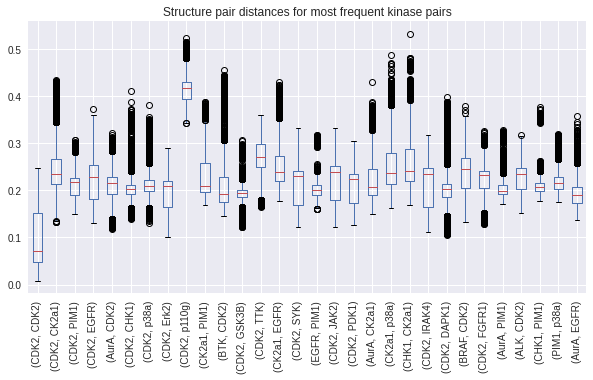

In [38]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10,5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

## Structure > kinase distances (median)

In [39]:
kinase_distances = structure_distances.groupby(["kinase1", "kinase2"]).median().reset_index()
kinase_distances.head()

,kinase1,kinase2,structure1,structure2,distance,coverage,distance_filtered
0,AAK1,AAK1,3835.0,7156.0,0.053726,0.995417,0.053726
1,AAK1,ABL1,1085.0,6679.0,0.243864,0.994167,0.243864
2,AAK1,ABL2,115.0,6679.0,0.244769,0.993750,0.244769
3,AAK1,ACK,3406.5,6679.0,0.231447,0.993750,0.229447
4,AAK1,ACTR2,2679.0,6679.0,0.239062,0.994167,0.239062


In [40]:
kinase_distances_filtered = kinase_distances[kinase_distances["distance_filtered"].notna()]

In [41]:
print(f"Kinase pairs: {kinase_distances.shape[0]}")
print(f"Kinase pairs not-NaN: {kinase_distances_filtered.shape[0]}")

Kinase pairs: 42717
Kinase pairs not-NaN: 40695


## Kinase matrix

### All distances

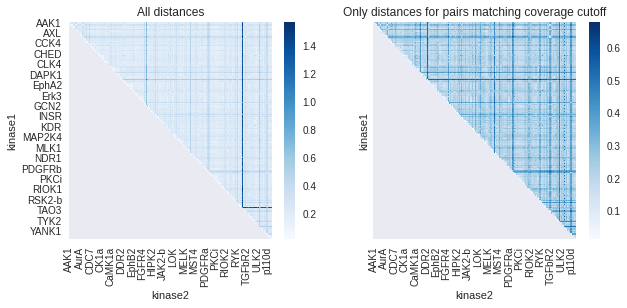

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
kinase_matrix = kinase_distances.pivot("kinase1", "kinase2", "distance")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("All distances")
kinase_matrix = kinase_distances.pivot("kinase1", "kinase2", "distance_filtered")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Only distances for pairs matching coverage cutoff");

In [43]:
def n_pairs(n):
    return int((n**2 - n) / 2 + n) 

In [44]:
n_structures = pd.concat([structure_distances['structure1'], structure_distances['structure2']]).unique().shape[0]
n_kinases = pd.concat([structure_distances['kinase1'], structure_distances['kinase2']]).unique().shape[0]
n_structures_filtered = pd.concat([structure_distances_filtered['structure1'], structure_distances_filtered['structure2']]).unique().shape[0]
n_kinases_filtered = pd.concat([structure_distances_filtered['kinase1'], structure_distances_filtered['kinase2']]).unique().shape[0]
 

table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0], 
        n_kinases,
        n_pairs(n_kinases),
        kinase_distances.shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        kinase_distances_filtered.shape[0],
    ]
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ]
)
table

,All distances,Only distances matching cutoff
Number of structures,4916,4877
Number of structure pairs (theory),12085986,11895003
Number of structure pairs (experimental),12081070,11851916
Number of kinases,292,285
Number of kinase pairs (theory),42778,40755
Number of kinase pairs (experimental),42717,40695


## Dual kinases paper dataset

https://www.mdpi.com/1420-3049/26/3/629

In [45]:
from itertools import combinations_with_replacement

In [46]:
KINASES_KLIFS_TO_PAPER = {
    'EGFR': 'EGFR',
    'ErbB2': 'ErbB2',
    'KDR': 'VEGFR2',
    'p110a': 'PI3K',
    'BRAF': 'BRAF',
    'CDK2': 'CDK2',
    'LCK': 'LCK',
    'MET': 'MET',
    'p38a': 'p38a',
}

In [47]:
example_kinases = list(KINASES_KLIFS_TO_PAPER.keys())
print(example_kinases)
example_kinase_pairs = [i for i in combinations_with_replacement(example_kinases, 2)]

['EGFR', 'ErbB2', 'KDR', 'p110a', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']


In [48]:
example_kinase_distances = kinase_distances_filtered[
    kinase_distances_filtered.apply(lambda x: (x["kinase1"], x["kinase2"]) in example_kinase_pairs, axis=1)
]

In [49]:
example_kinase_distances.shape

(35, 7)

In [50]:
example_kinase_matrix = example_kinase_distances.pivot("kinase1", "kinase2", "distance")
example_kinase_matrix = example_kinase_matrix.loc[example_kinases, example_kinases]
example_kinase_matrix

kinase2,EGFR,ErbB2,KDR,p110a,BRAF,CDK2,LCK,MET,p38a
kinase1,,,,,,,,,
EGFR,0.09559,0.175204,0.179958,0.367720,NaN,NaN,0.162322,0.213161,0.227858
ErbB2,NaN,0.171325,0.238566,0.345473,NaN,NaN,0.243790,0.232069,0.280568
KDR,NaN,NaN,0.073128,0.374093,NaN,NaN,0.171769,0.203195,0.214081
p110a,NaN,NaN,NaN,0.053996,NaN,NaN,NaN,NaN,0.376979
BRAF,NaN,NaN,NaN,NaN,0.130854,0.255630,0.233121,0.242547,0.264635
CDK2,NaN,NaN,NaN,NaN,NaN,0.071505,0.228544,0.234183,0.215778
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.045253,0.211339,0.215140
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116751,0.257243
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.114204


In [51]:
example_kinase_matrix.columns = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.columns]
example_kinase_matrix.index = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.index]
example_kinase_matrix

,EGFR,ErbB2,VEGFR2,PI3K,BRAF,CDK2,LCK,MET,p38a
EGFR,0.09559,0.175204,0.179958,0.367720,NaN,NaN,0.162322,0.213161,0.227858
ErbB2,NaN,0.171325,0.238566,0.345473,NaN,NaN,0.243790,0.232069,0.280568
VEGFR2,NaN,NaN,0.073128,0.374093,NaN,NaN,0.171769,0.203195,0.214081
PI3K,NaN,NaN,NaN,0.053996,NaN,NaN,NaN,NaN,0.376979
BRAF,NaN,NaN,NaN,NaN,0.130854,0.255630,0.233121,0.242547,0.264635
CDK2,NaN,NaN,NaN,NaN,NaN,0.071505,0.228544,0.234183,0.215778
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.045253,0.211339,0.215140
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116751,0.257243
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.114204


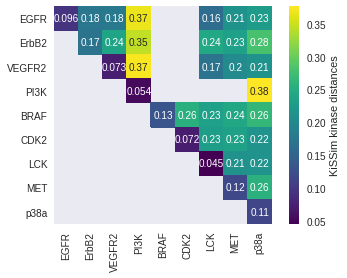

In [52]:
sns.heatmap(
    example_kinase_matrix, 
    linewidths=0, 
    annot=True, 
    square=True, cbar_kws={'label': 'KiSSim kinase distances'}, 
    cmap='viridis', 
)
plt.show()

Compare to paper (shows similarities; not distances; __so think values inverse__):

![](https://www.mdpi.com/molecules/molecules-26-00629/article_deploy/html/images/molecules-26-00629-g002.png)

Figure 2. Heat maps of pairwise kinase similarities for the different measures used in this work: (A) ligand profile similarity (LigProfSim); (B) pocket sequence similarity (PocSeqSim); (C) interaction fingerprint similarity (IFPSim); (D) pocket structure similarity (PocStrucSim); and (E) docking rank similarity (DockRankSim) based on the lead-like subset of ZINC. Note that docking was only performed for the five kinases of Profiles 1–4, thus the remaining entries remain empty (white) in the matrix.